## Install the following libraries, if not done already, before running the below script

#### !pip install tensorflow
#### !pip install scikit-learn
#### !pip install numpy 
#### !pip install pandas 
#### !pip install pyDOE 
#### !pip install scipy
#### !pip install matplotlib

In [ ]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit

# Ensure reproducibility
np.random.seed(42)
tf.random.set_random_seed(42)


# Material constants
E = 19300e6  # Young's modulus in MPa
sigma_y = 150e6  # Yield stress in MPa
h = 100  # Isotropic hardening rate


def generate_strain_history(num_samples, lb, ub):
    """
    Generate a cyclic strain history.

    :param num_samples: Total number of samples
    :param lb: Lower bound for strain increment
    :param ub: Upper bound for strain increment
    :return: Strain history
    """
    strain_history = np.zeros(3900)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = 0.0001
        cumulative_strain += increment^ 
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = 0.0001
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, 1600):
        increment = 0.0001
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
    
    for i in range(1600, 2300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain
    
    for i in range(2300, 3100):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
        
    for i in range(3100, 3900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    return strain_history
    

# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, h, alpha, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    yield_function = np.abs(sigma_trial) - (sigma_y + h * alpha)
    return sigma_trial, yield_function


# Von Mises return mapping algorithm
def von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        sigma_updated = sigma_trial
        eps_p = eps_p
        alpha = alpha
        delta_gamma=0
        sign = sigma_trial/np.abs(sigma_trial)
    else:
        # Plastic step
        delta_gamma = yield_function / (E + h)
        eps_p = eps_p + delta_gamma* (sigma_trial/np.abs(sigma_trial))
        alpha = alpha + delta_gamma
        #sigma_updated = sigma_trial - E * delta_gamma
        sigma_updated = E*(eps-eps_p)
        sign = sigma_trial/np.abs(sigma_trial)

    return sigma_updated, eps_p, alpha, delta_gamma, sign


# Generate dataset
def generate_dataset(lb, ub, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(num_strain_samples, lb, ub)
    # Initialize state variables
    alpha, eps_p, delta_gamma = 0, 0, 0
    
    for eps in strain_history:
        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, h, alpha, sigma_y)

        # Return mapping algorithm
        sigma_updated, eps_p, alpha, delta_gamma, sign  = von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y)

        # Store the data
        dataset.append([
            E,sigma_y,h, yield_function, eps, sigma_updated, eps_p, alpha, sign, delta_gamma
        ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_von_mises_training_07_01_2025.csv"):
    columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cummulative eps_p", "alpha",'sign', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")


In [65]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_strain_samples=2100)
test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

In [66]:
columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cumulative_plastic_strain", "alpha", 'sign','plastic_strain']
df = pd.DataFrame(training, columns=columns)

In [67]:
df[300:350]

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
300,1.930000e+10,150000000.0,100.0,-2.029746e+06,0.044751,1.479703e+08,0.037084,0.037084,1.0,0.0
301,1.930000e+10,150000000.0,100.0,-4.985260e+06,0.044598,1.450147e+08,0.037084,0.037084,1.0,0.0
302,1.930000e+10,150000000.0,100.0,-7.958686e+06,0.044444,1.420413e+08,0.037084,0.037084,1.0,0.0
303,1.930000e+10,150000000.0,100.0,-1.111893e+07,0.044280,1.388811e+08,0.037084,0.037084,1.0,0.0
304,1.930000e+10,150000000.0,100.0,-1.445028e+07,0.044107,1.355497e+08,0.037084,0.037084,1.0,0.0
305,1.930000e+10,150000000.0,100.0,-1.826368e+07,0.043910,1.317363e+08,0.037084,0.037084,1.0,0.0
306,1.930000e+10,150000000.0,100.0,-2.119014e+07,0.043758,1.288099e+08,0.037084,0.037084,1.0,0.0
307,1.930000e+10,150000000.0,100.0,-2.374344e+07,0.043626,1.262566e+08,0.037084,0.037084,1.0,0.0
308,1.930000e+10,150000000.0,100.0,-2.720815e+07,0.043446,1.227919e+08,0.037084,0.037084,1.0,0.0
309,1.930000e+10,150000000.0,100.0,-2.966086e+07,0.043319,1.203391e+08,0.037084,0.037084,1.0,0.0


In [68]:
save_dataset_to_csv(training)

Dataset saved to generated_dataset_von_mises_training_07_01_2025.csv


In [69]:
df=df.fillna(1)

In [70]:
df.isna().sum()

E                            0
sigma_y                      0
h                            0
yield_function               0
strain                       0
sigma_updated                0
cumulative_plastic_strain    0
alpha                        0
sign                         0
plastic_strain               0
dtype: int64

In [71]:
df.head(50)

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
0,1.930000e+10,150000000.0,100.0,-1.473471e+08,0.000137,2.652862e+06,0.0,0.0,1.0,0.0
1,1.930000e+10,150000000.0,100.0,-1.435823e+08,0.000333,6.417741e+06,0.0,0.0,1.0,0.0
2,1.930000e+10,150000000.0,100.0,-1.402395e+08,0.000506,9.760489e+06,0.0,0.0,1.0,0.0
3,1.930000e+10,150000000.0,100.0,-1.371541e+08,0.000666,1.284590e+07,0.0,0.0,1.0,0.0
4,1.930000e+10,150000000.0,100.0,-1.349230e+08,0.000781,1.507702e+07,0.0,0.0,1.0,0.0
5,1.930000e+10,150000000.0,100.0,-1.326919e+08,0.000897,1.730809e+07,0.0,0.0,1.0,0.0
6,1.930000e+10,150000000.0,100.0,-1.306498e+08,0.001003,1.935019e+07,0.0,0.0,1.0,0.0
7,1.930000e+10,150000000.0,100.0,-1.270481e+08,0.001189,2.295191e+07,0.0,0.0,1.0,0.0
8,1.930000e+10,150000000.0,100.0,-1.239579e+08,0.001349,2.604206e+07,0.0,0.0,1.0,0.0
9,1.930000e+10,150000000.0,100.0,-1.206614e+08,0.001520,2.933864e+07,0.0,0.0,1.0,0.0


In [72]:
df.tail(50)

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
3850,1.930000e+10,150000000.0,100.0,2.736097e+06,-0.036349,-1.500000e+08,-0.028577,0.491431,-1.0,0.000142
3851,1.930000e+10,150000000.0,100.0,2.154572e+06,-0.036461,-1.500000e+08,-0.028689,0.491543,-1.0,0.000112
3852,1.930000e+10,150000000.0,100.0,3.112696e+06,-0.036622,-1.500000e+08,-0.028850,0.491704,-1.0,0.000161
3853,1.930000e+10,150000000.0,100.0,3.741271e+06,-0.036816,-1.500000e+08,-0.029044,0.491898,-1.0,0.000194
3854,1.930000e+10,150000000.0,100.0,3.207231e+06,-0.036982,-1.500000e+08,-0.029210,0.492064,-1.0,0.000166
3855,1.930000e+10,150000000.0,100.0,2.078230e+06,-0.037090,-1.500000e+08,-0.029318,0.492172,-1.0,0.000108
3856,1.930000e+10,150000000.0,100.0,2.614506e+06,-0.037226,-1.500000e+08,-0.029453,0.492308,-1.0,0.000135
3857,1.930000e+10,150000000.0,100.0,2.992780e+06,-0.037381,-1.500000e+08,-0.029609,0.492463,-1.0,0.000155
3858,1.930000e+10,150000000.0,100.0,2.708191e+06,-0.037521,-1.500000e+08,-0.029749,0.492603,-1.0,0.000140
3859,1.930000e+10,150000000.0,100.0,3.538933e+06,-0.037704,-1.500000e+08,-0.029932,0.492786,-1.0,0.000183


In [73]:
strain_training= training[:,-6]
strain_test1= test1[:,-6]
strain_test2= test2[:,-6]

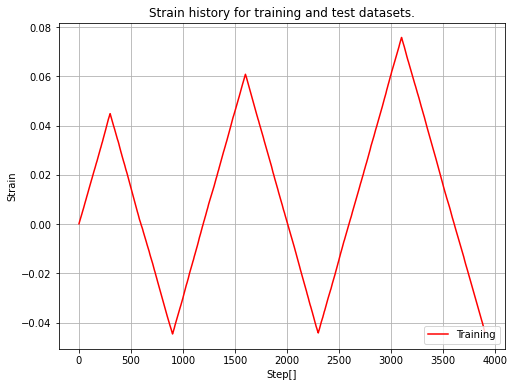

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

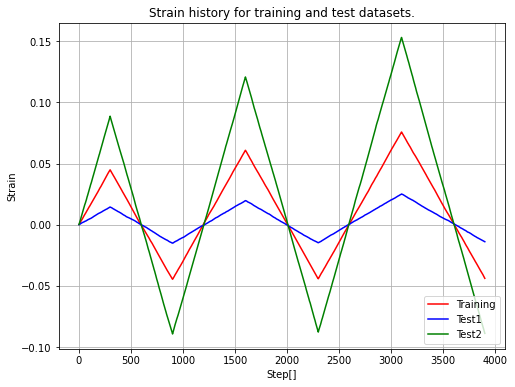

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.plot(strain_test1, label='Test1', color='blue')
plt.plot(strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

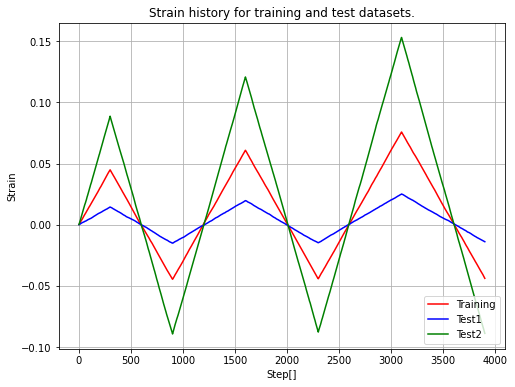

In [76]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.plot(strain_test1, label='Test1', color='blue')
plt.plot(strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

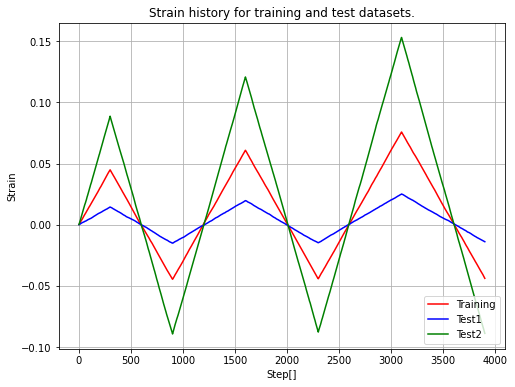

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.plot(strain_test1, label='Test1', color='blue')
plt.plot(strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [78]:
sign_training= training[:,-2]
sign_test1= test1[:,-2]
sign_test2= test2[:,-2]

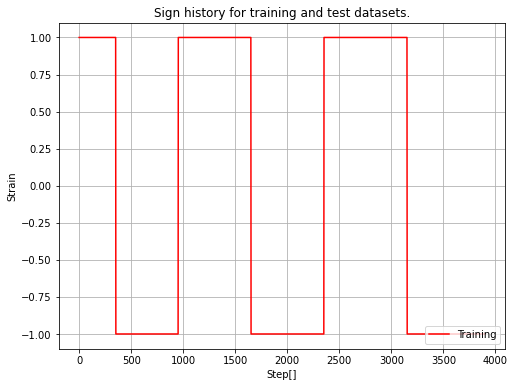

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(sign_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Sign history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [80]:
cm_plastic_strain_training= training[:,-4]
cm_plastic_strain_test1= test1[:,-4]
cm_plastic_strain_test2= test2[:,-4]

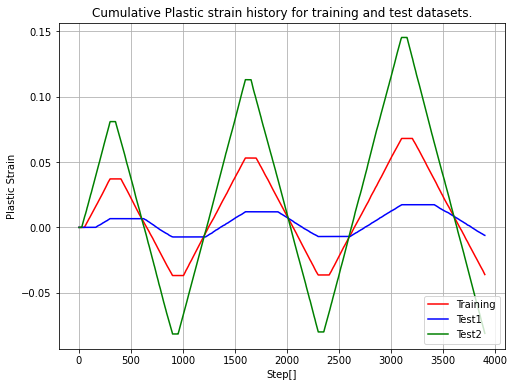

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(cm_plastic_strain_training, label='Training', color='red')
plt.plot(cm_plastic_strain_test1, label='Test1', color='blue')
plt.plot(cm_plastic_strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Cumulative Plastic strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [82]:
plastic_strain_training= training[:,-1]
plastic_strain_test1= test1[:,-1]
plastic_strain_test2= test2[:,-1]

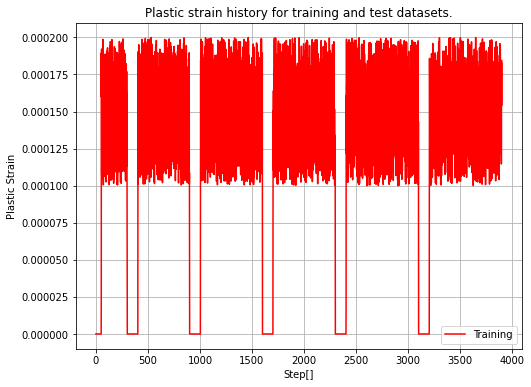

In [83]:
plt.figure(figsize=(8, 6))
plt.plot(plastic_strain_training, label='Training', color='red')
#plt.plot(plastic_strain_test1, label='Test1', color='blue')
#plt.plot(plastic_strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Plastic strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [84]:
alpha_training= training[:,-3]
alpha_test1= test1[:,-3]
alpha_test2= test2[:,-3]

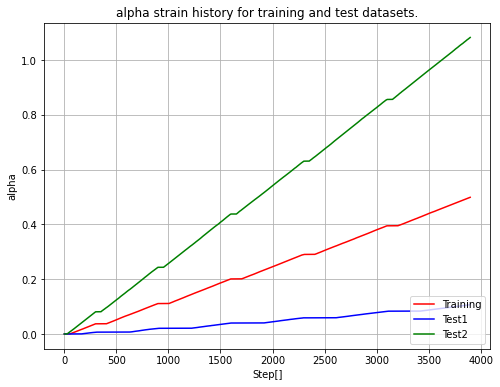

In [85]:
plt.figure(figsize=(8, 6))
plt.plot(alpha_training, label='Training', color='red')
plt.plot(alpha_test1, label='Test1', color='blue')
plt.plot(alpha_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('alpha')
plt.title('alpha strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [86]:
print(np.isnan(training).any())
print(np.isinf(training).any())

False
False


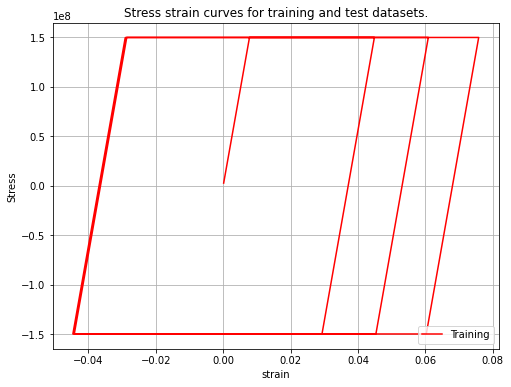

In [87]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], training[:,5], label='Training', color='red')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()